<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades</p>
<p style="margin: 0; text-align:right;">2022-2 · Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PAC 3: Mètodes supervisats

En aquesta pràctica veurem diferents mètodes supervisats i intentarem optimitzar diferents mètriques. Veurem com els diferents models classifiquen els punts i amb els quals obtenim més precisió. Després aplicarem tot allò que hem après fins ara a un dataset nou, simulant un cas pràctic real.

1. Exploració d'algorismes supervisats <br>
     1.0. Càrrega de dades <br>
     1.1. Naive-Bayes<br>
     1.2. Anàlisi Discriminant Lineal (LDA) i Anàlisi Discriminant Quadràtica (QDA)<br>
     1.3. K veïns més propers (KNN)<br>
     1.4. Màquines de suport vectorial (SVM)<br>
     1.5. Arbres de decisió 
2. Implementació del cas pràctic <br>
     2.0. Càrrega de dades<br>
     2.1. Anàlisi descriptiva<br>
     2.2. Entrenament, validació i prova d'una xarxa neuronal amb les dades originals<br>
     2.3. Submostreig<br>
     2.4. Sobremostreig<br>
     2.5. Generació de dades sintètiques<br>
     2.6. _Tuning_ dels models (BONUS)

<u>Consideracions generals</u>:

- La solució plantejada no pot utilitzar mètodes, funcions o paràmetres declarats **_deprecated_** en futures versions, a excepció de la càrrega de dades com s'indica posteriorment.
- Aquesta PAC s'ha de fer de manera **estrictament individual**. Qualsevol indici de còpia serà penalitzat amb un suspens (D) per a totes les parts implicades i la possible avaluació negativa de l'assignatura de forma íntegra.
- Cal que l'estudiant indiqui **totes les fonts** que ha fet servir per a la realització de la PAC. Si no és així, es considerarà que l'estudiant ha comès plagi, i és penalitzat amb un suspens (D) i la possible avaluació negativa de l'assignatura de forma íntegra.

<u>Format del lliurament</u>:

- Alguns exercicis poden suposar diversos minuts d'execució, per la qual cosa el lliurament s'ha de fer en **format notebook** i en **format html**, on es vegi el codi, els resultats i comentaris de cada exercici. Es pot exportar el notebook a HTML des del menú File $\to$ Download as $\to$ HTML.
- Hi ha un tipus de cel·la especial per contenir text. Aquest tipus de cel·la us serà molt útil per respondre a les diferents preguntes teòriques plantejades al llarg de l'activitat. Per canviar el tipus de cel·la a aquest tipus, aneu al menú: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
    <strong>Nom i cognoms: XAVIER MALTAS TARRIDAS</strong>
</div>

In [1]:
import numpy as np 
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


<a id='ex1'></a>
# 1. Exploració d'algorismes supervisats (5 punts)

## 1.0. Càrrega de dades

El conjunt de dades Spiral és un conjunt de dades sintètiques que s'utilitza habitualment en l'aprenentatge automàtic i la mineria de dades com un problema de classificació no lineal. El conjunt de dades consta de dues espirals entrellaçades que s'assemblen a les espirals d'Arquimedes. Cada espiral es compon d'un conjunt de punts distribuïts uniformement al pla, i els punts de cada espiral estan etiquetats amb una classe diferent.

L'objectiu és utilitzar un algorisme de classificació per predir la classe d'un punt desconegut en funció de les coordenades (x, y). A causa de la naturalesa entrellaçada de les espirals, aquest problema de classificació és no lineal i, per tant, és un desafiament interessant per als algorismes d'aprenentatge automàtic.

El codi següent carregarà 2000 punts a la variable `X` i la corresponent etiqueta o grup (en forma numèrica) a la variable `y`. Podem comprovar que la càrrega ha estat correcta obtenint les dimensions d'aquestes dues variables i el gràfic dels punts (amb colors diferents per a cada grup).

Dimensions de X (2000, 2)
Dimensions de y (2000,)


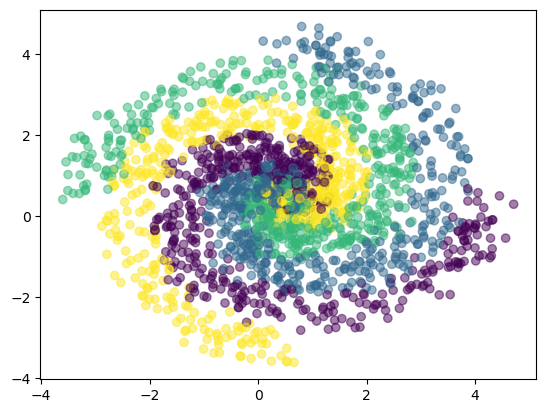

In [2]:
data = pd.read_pickle('spiral.pickle')

# Convertir les dues primeres columnes en un array de numpy
X = data[['X1', 'X2']].values

# Convertir l'última columna en un array de numpy
y = data['y'].values

print('Dimensions de X', X.shape)
print('Dimensions de y', y.shape)

# Fer la representació gràfica
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.viridis, alpha=0.5)
plt.show()

Al llarg dels exercicis aprendrem a veure gràficament les fronteres de decisió que ens tornen els diferents models. Per això utilitzarem la funció definida a continuació, que segueix els passos següents:

   - Crear una [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) amb els valors mínim i màxim de 'x' i 'y'.
   - Predir el classificador amb els valors de la _meshgrid_.
   - Fer un _reshape_ de les dades per tenir el format corresponent.
  
Un cop fet això, ja podem fer el gràfic de les fronteres de decisió i afegir-hi els punts reals. Així veurem les àrees que considera que el model són d'una classe i les que considera que són d'una altra. En sobreposar els punts, veurem si els classifica correctament a l'àrea que els correspon.

In [3]:
def plot_decision_boundary(clf, X, Y, cmap='Paired'):
    if not isinstance(X, np.ndarray):  # Si X no és un array de numpy, el converteix
        X = X.to_numpy()
    
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,7))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap, edgecolors='k', label=Y);

<div class="alert alert-block alert-info">
   <strong>Implementació:</strong>

Dividiu el _dataset_ en dos subconjunts, __*train*__ (80% de les dades) i __*test*__ (20% de les dades). Anomeneu els conjunts com: X_train, X_test, y_train, y_test. Utilitzeu l'opció `random_state = 24`.
    
Podeu utilitzar la implementació `train_test_split` de `sklearn`.
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

In [4]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Printing the shapes of the resulting subsets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1600, 2)
X_test shape: (400, 2)
y_train shape: (1600,)
y_test shape: (400,)


## 1.1. Gaussian Naïve Bayes

L'objectiu d'aquest primer exercici és entendre el funcionament de l'algorisme Naïve-Bayes, un algoritme peculiar, ja que es basa en el teorema de Bayes per calcular la probabilitat que una observació pertanyi a cadascuna de les classes. El model assumeix que les característiques d'entrada són independents entre si, cosa que permet simplificar el càlcul de les probabilitats condicionals.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Amb el dataset de _train_, entreneu un model de Naïve-Bayes. Podeu utilitzar el classificador `GaussianNB` de `sklearn`.

- Calculeu el _accuracy_ del model obtingut sobre _train_ i _test_.

- Calculeu la matriu de confusió sobre _test_.
    
- Representeu gràficament la frontera de decisió amb el conjunt de _test_.
    
Podeu utilitzar la funció `plot_decision_boundary` creada prèviament, i les funcions `accuracy_score` i `confusion_matrix` del paquet `metrics` de `sklearn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

Train Accuracy: 0.294375
Test Accuracy: 0.2475
Confusion Matrix:
[[15 27 27 33]
 [32 37 10 31]
 [32 35 23  9]
 [18 23 24 24]]


<Figure size 1000x800 with 0 Axes>

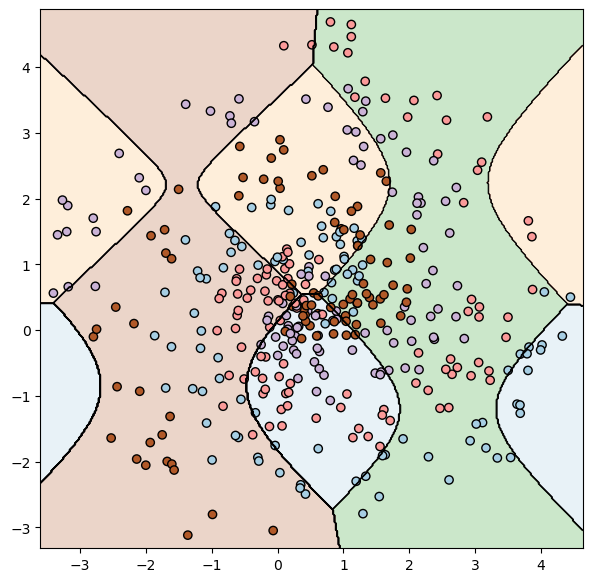

In [5]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

# Training the Naïve-Bayes model
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

# Making predictions on the train and test datasets
train_predictions = naive_bayes.predict(X_train)
test_predictions = naive_bayes.predict(X_test)

# Calculating the accuracy on the train and test datasets
train_accuracy = metrics.accuracy_score(y_train, train_predictions)
test_accuracy = metrics.accuracy_score(y_test, test_predictions)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Computing the confusion matrix on the test dataset
confusion_matrix = metrics.confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(confusion_matrix)

# Plotting the decision boundary with the test set
plt.figure(figsize=(10, 8))
plot_decision_boundary(naive_bayes, X_test, y_test)
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

- Com són les fronteres de decisió? Té sentit que tinguin aquesta forma amb l'algoritme utilitzat?
- Com són les prediccions obtingudes sobre el conjunt de test?
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong> 


</div>

El classificador de Gauss Naïve Bayes assumeix que les característiques (descriptors) segueixen una distribució gaussiana (normal). Amb aquesta suposició, els límits del classificador es poden entendre considerant les probabilitats de les diferents classes. Cada classe es modela per una distribució gaussiana amb la seva pròpia mitjana i variància per a cada característica. Els límits de decisió es defineixen per les regions on la probabilitat posterior de cada classe és la més alta. La forma dels límits està influenciada pels mitjans i variàncies de les distribucions gaussianes per a cada classe.
Observant els resultats dels límits de decisió amb el conjunt de test veiem que les prediccions de la classificació realitzada, tenen una precisió molt reduïda i unes fronteres de decisió molt diferents de les esperades.

## 1.2 Anàlisi Discriminant Lineal (LDA) i Anàlisi Discriminant Quadràtica (QDA)

Ara analitzarem dos algorismes que es basen en la transformació lineal de les característiques d'entrada per maximitzar la separació entre les classes. Aquests models suposen que les característiques tenen una distribució gaussiana, i així, poder calcular les probabilitats condicionals de cada classe i assignar la classe amb la major probabilitat com la classe predita per a una observació donada.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Amb el dataset de _train_, entreneu un model d'Anàlisi Discriminate Lineal (LDA). Podeu utilitzar el classificador `LinearDiscriminantAnalysis` de `sklearn`.

- Calculeu el _accuracy_ del model obtingut sobre _train_ i _test_.

- Calculeu la matriu de confusió sobre _test_.
    
- Representeu gràficament la frontera de decisió amb el conjunt de _test_.

</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

Train Accuracy: 0.255
Test Accuracy: 0.2475
Confusion Matrix:
[[24 29 24 25]
 [27 27 21 35]
 [27 28 24 20]
 [17 25 23 24]]


<Figure size 1000x800 with 0 Axes>

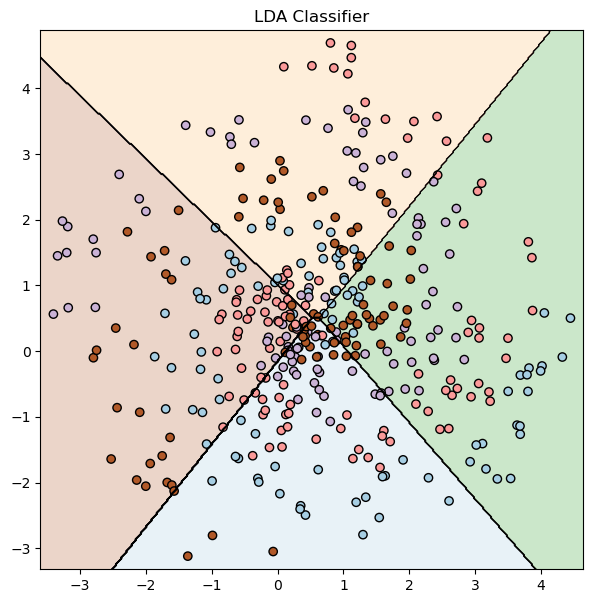

In [7]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics

# Training the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Making predictions on the train and test datasets
train_predictions = lda.predict(X_train)
test_predictions = lda.predict(X_test)

# Calculating the accuracy on the train and test datasets
train_accuracy = metrics.accuracy_score(y_train, train_predictions)
test_accuracy = metrics.accuracy_score(y_test, test_predictions)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Computing the confusion matrix on the test dataset
confusion_matrix = metrics.confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(confusion_matrix)

# Plotting the decision boundary with the test set
plt.figure(figsize=(10, 8))
plot_decision_boundary(lda, X_test, y_test)
plt.title(f"LDA Classifier")
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

- Com són les fronteres de decisió? Té sentit que tinguin aquesta forma amb l'algoritme utilitzat?
- Com són les prediccions obtingudes sobre el conjunt de test?
</div>

Els límits d'un classificador de model d'Anàlisi Discriminant Lineal (LDA) són límits de decisió lineals. Aquest busca trobar una combinació lineal de característiques que maximitzi la separació entre diferents classes. LDA assumeix que les dades de cada classe es distribueixen normalment i que les matrius de covariància de les classes són iguals. Basant-se en aquestes suposicions, LDA calcula els vectors mitjans i la matriu de covariància de les classes i els utilitza per calcular un vector de projecció anomenat "vector discriminant" o "funció discriminant lineal". El límit de decisió en LDA es defineix per una equació lineal en l'espai de característiques. Aquesta equació lineal s'obté trobant l'hiperplà que separa maximalment les classes. L'hiperplà es defineix pel vector discriminant, que determina la direcció en la qual la projecció dels punts de dades sobre l'hiperplà està maximalment separada. El límit de decisió en LDA és un separador lineal, el que significa que és un hiperplà que separa l'espai de característiques en diferents regions corresponents a diferents classes. El model LDA aprèn l'hiperplà òptim que maximitza la separació entre classes basant-se en les propietats estadístiques de les dades.
Un cop entès com funciona i treballa un model de tipus LDA, si observem els resultats dels límits de decisió amb el conjunt de test veiem que les prediccions de la classificació realitzada, generen unes fronteres molt marcades en forma de X, entregant una precisió molt reduïda i pobra.

<div class="alert alert-block alert-success">
<strong>Resposta:</strong> 


</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 

- Amb el dataset de _train_, entreneu un model d'Anàlisi Discriminant Quadràtica (QDA). Podeu utilitzar el classificador `QuadraticDiscriminantAnalysis` de `sklearn`.

- Calculeu el _accuracy_ del model obtingut sobre _train_ i _test_.

- Calculeu la matriu de confusió sobre _test_.
    
- Representeu gràficament la frontera de decisió amb el conjunt de _test_.

</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

Train Accuracy: 0.26375
Test Accuracy: 0.215
Confusion Matrix:
[[28 13 33 28]
 [40 18 11 41]
 [38 36 19  6]
 [16 29 23 21]]


<Figure size 1000x800 with 0 Axes>

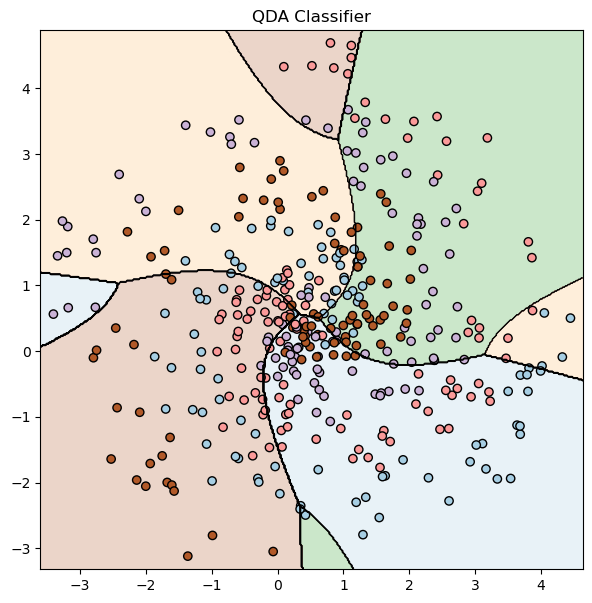

In [8]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

# Training the QDA model
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# Making predictions on the train and test datasets
train_predictions = qda.predict(X_train)
test_predictions = qda.predict(X_test)

# Calculating the accuracy on the train and test datasets
train_accuracy = metrics.accuracy_score(y_train, train_predictions)
test_accuracy = metrics.accuracy_score(y_test, test_predictions)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Computing the confusion matrix on the test dataset
confusion_matrix = metrics.confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(confusion_matrix)

# Plotting the decision boundary with the test set
plt.figure(figsize=(10, 8))
plot_decision_boundary(qda, X_test, y_test)
plt.title(f"QDA Classifier")
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

- Com són les fronteres de decisió? Té sentit que tinguin aquesta forma amb l'algoritme utilitzat?
- Com són les prediccions obtingudes sobre el conjunt de test?
- En què es diferencien l'algorisme LDA i QDA?
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong> 


</div>

Els límits d'un classificador de model d'Anàlisi Discriminant Quadràtica (QDA) són límits de decisió quadràtics. QDA és un algorisme de classificació que estén l'Anàlisi Discriminant Lineal (LDA) relaxant l'assumpció de matrius de covariància iguals entre classes. Igual que succeeix a LDA, QDA assumeix que les dades de cada classe es distribueixen normalment. Tanmateix, en un model de tipus QDA, cada classe es modela per la seva pròpia matriu de covariància, permetent d'aquesta manera límits de decisió més flexibles. En lloc d'assumir matrius de covariància iguals, QDA estima una matriu de covariància separada per a cada classe.
El límit de decisió en QDA es defineix per una equació quadràtica en l'espai de característiques. A diferència del límit de decisió lineal en LDA, el límit de decisió en QDA pot prendre una forma corba. Això permet a la QDA capturar relacions més complexes entre les característiques i les classes. El límit de decisió que trobem en un QDA, es tracta d'un separador quadràtic, sent d'aquesta manera un corba la responsable de separar l'espai de característiques en diferents regions corresponents a diferents classes. QDA és capaç de capturar límits de decisió més complexos en comparació amb LDA, que poden ser avantatjosos quan es tracta de relacions no lineals entre característiques i classes. Finalment, després d'entendre el funcionament d'un model de tipus QDA i quines són les diferències principals respecte a un classificador LDA, podem veure que els resultats dels límits de decisió amb el conjunt de test són més flexibles. Tot i això, podem veure que la classificació realitzada en aquest cas continua tenint uns valors de precisió molt baix, fins i tot inferior a l'obtingut pel classificador LDA.

## 1.3. K veïns més propers (KNN)

En aquest punt entendrem el funcionament de l'algorisme KNN (que es basa en la proximitat dels punts de dades en un espai de característiques), intuir-ne els principals avantatges o desavantatges i entendre la influència dels paràmetres de què està compost.

_K-Nearest Neighbor_ és un algorisme basat en instància de tipus supervisat.

Veurem què significa això:

   - Supervisat: tenim etiquetatge el nostre conjunt de dades d'entrenament, amb la classe o resultat esperat.
   - Basat en instància (_Lazy Learning_): Això significa que el nostre algorisme no aprèn explícitament un model (com per exemple en Regressió Logística o arbres de decisió), sinó que memoritza les instàncies d'entrenament que són utilitzades com a "coneixement" per a la fase de predicció.

Com funciona el KNN?

   - Calculem la distància entre l'ítem a classificar i els altres ítems del dataset d'entrenament.
   - Seleccionem els "k" elements més propers, és a dir, amb menor distància, segons la distància que definim (euclidiana, cosinus, manhattan, etc).
   - Finalment, fem una "votació de majoria" entre els k punts: els de la classe que "dominen" decidiran la seva classificació final.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Amb el dataset de _train_, entreneu un classificador KNN amb hiperparàmetre `n_neighbors=2`. Podeu utilitzar el classificador `KNeighborsClassifier` de `sklearn`.

- Calculeu el _accuracy_ del model obtingut sobre _train_ i _test_.

- Calculeu la matriu de confusió sobre _test_.
    
- Representeu gràficament la frontera de decisió amb el conjunt de _test_.


Si en entrenar el classificador us apareix un _warning_ i el voleu ignorar, executeu el codi següent abans de l'entrenament:

> import warnings<br>
> warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)

</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

In [15]:
import warnings
warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)

Train Accuracy: 0.883125
Test Accuracy: 0.775
Confusion Matrix:
[[88  6  1  7]
 [11 93  5  1]
 [ 5 15 77  2]
 [14  5 18 52]]


<Figure size 1000x800 with 0 Axes>

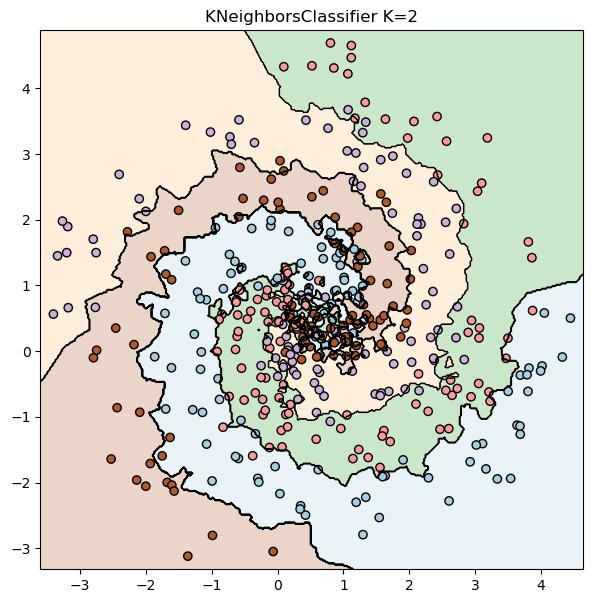

In [10]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Training the KNN classifier
n_neighbors=2
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, y_train)

# Making predictions on the train and test datasets
train_predictions = knn.predict(X_train)
test_predictions = knn.predict(X_test)

# Calculating the accuracy on the train and test datasets
train_accuracy = metrics.accuracy_score(y_train, train_predictions)
test_accuracy = metrics.accuracy_score(y_test, test_predictions)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Computing the confusion matrix on the test dataset
confusion_matrix = metrics.confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(confusion_matrix)

# Plotting the decision boundary with the test set
plt.figure(figsize=(10, 8))
plot_decision_boundary(knn, X_test, y_test)
plt.title(f"KNeighborsClassifier K=%d" % n_neighbors)
plt.show()


Al model entrenat, hem fixat el paràmetre `n_neighbors` de forma arbitrària. Però podria ser que amb un altre valor obtinguéssim una millor predicció.

Per conèixer el valor òptim dels paràmetres d'un model (_hyperparameter tunning_) se sol utilitzar una cerca de reixeta (_grid search_). És a dir, entrenar un model per a cada combinació d'hiperparàmetres possible i avaluar-lo fent servir validació creuada (_cross validation_) amb 5 particions estratificades. Posteriorment, s'escull la combinació d'hiperparàmetres que hagi obtingut millors resultats.

En aquest cas, només volem optimitzar un hiperparàmetre:

- _k_: el nombre de veïns que es consideren per classificar un nou exemple. Provarem amb tots els valors entre 1 i 20.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong>

Calculeu del valor òptim de l'hiperparàmetre _k_ (`n_neighbors`). Utilitzeu una cerca de reixeta amb validació creuada per trobar el valor òptim de _k_. Per cada valor, calculeu la seva mitjana i la desviació estàndard. Implementeu un _heatmap_ per visualitzar la precisió segons els diferents valors de l'hiperparàmetre.
    
Podeu utilitzar el mòdul `GridSearchCV` de `sklearn` pel càlcul del millor hiperparàmetre, i `heatmap` de `Seaborn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

Accuracy values from k=[1,20]: 
 [[0.74875 ]
 [0.76125 ]
 [0.78125 ]
 [0.778125]
 [0.79375 ]
 [0.794375]
 [0.79125 ]
 [0.795625]
 [0.785625]
 [0.79625 ]
 [0.798125]
 [0.791875]
 [0.800625]
 [0.80125 ]
 [0.80375 ]
 [0.803125]
 [0.793125]
 [0.798125]
 [0.79875 ]
 [0.799375]]


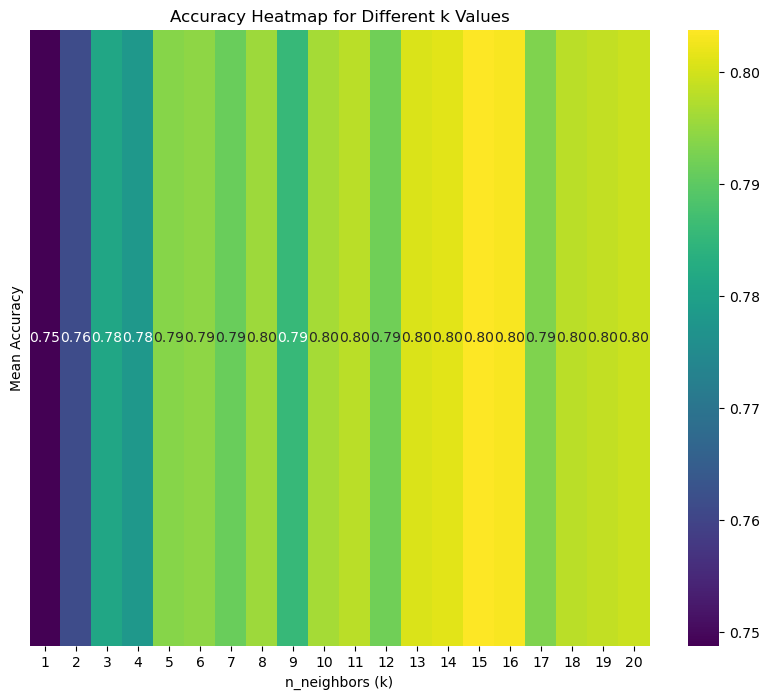

Best k value: 15
Confusion Matrix:
[[75  9  2 16]
 [ 8 93  9  0]
 [ 5  7 82  5]
 [10  3 10 66]]


In [11]:
#Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Define the range of k values to explore
k_values = np.arange(1, 21)

# Create a KNN classifier object
knn = KNeighborsClassifier()

# Define the parameter grid for grid search
param_grid = {'n_neighbors': k_values}

# Create a GridSearchCV object
# grid_search = GridSearchCV(knn, param_grid, scoring='precision')
grid_search = GridSearchCV(knn, param_grid, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the results of the grid search
results = grid_search.cv_results_

# Extract the mean and standard deviation of accuracy for each value of k
mean_accuracy = results['mean_test_score']
std_accuracy = results['std_test_score']

# Reshape the mean and standard deviation arrays to a square grid
mean_accuracy_grid = mean_accuracy.reshape(-1, 1)
std_accuracy_grid = std_accuracy.reshape(-1, 1)

print("Accuracy values from k=[1,20]: \n" ,mean_accuracy_grid)

# Create a heatmap to display accuracy according to different k values
plt.figure(figsize=(10, 8))
sns.heatmap(mean_accuracy.reshape(1, -1), annot=True, fmt='.2f', cmap='viridis', cbar=True,
            xticklabels=k_values, yticklabels=False)
plt.xlabel('n_neighbors (k)')
plt.ylabel('Mean Accuracy')
plt.title('Accuracy Heatmap for Different k Values')
plt.show()

# Get the best k value
best_k = grid_search.best_params_['n_neighbors']
print("Best k value:", best_k)

# Retrain the KNN classifier with the best k value
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

# Make predictions on the test dataset with the best model
test_predictions = knn_best.predict(X_test)

# Calculate the confusion matrix on the test dataset
confusion_matrix = metrics.confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(confusion_matrix)

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Amb el dataset de _train_, entreneu un classificador KNN amb el millor hiperparàmetre trobat.

- Calculeu el _accuracy_ del model obtingut sobre _train_ i _test_.

- Calculeu la matriu de confusió sobre _test_.
    
- Representeu gràficament la frontera de decisió amb el conjunt de _test_.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

Best k value: 15
Train Accuracy: 0.83125
Test Accuracy: 0.79
Confusion Matrix:
[[75  9  2 16]
 [ 8 93  9  0]
 [ 5  7 82  5]
 [10  3 10 66]]


Text(0.5, 1.0, 'KNeighborsClassifier K=15')

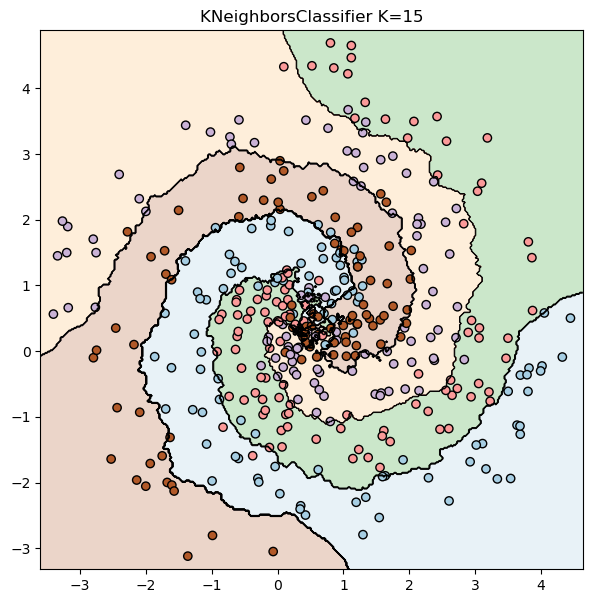

In [12]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

print("Best k value:", best_k)

# Make predictions on the train and test datasets
train_predictions = knn_best.predict(X_train)
test_predictions = knn_best.predict(X_test)

# Calculate the accuracy of the model on the train and test datasets
train_accuracy = metrics.accuracy_score(y_train, train_predictions)
test_accuracy = metrics.accuracy_score(y_test, test_predictions)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Calculate the confusion matrix on the test dataset
confusion_matrix = metrics.confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(confusion_matrix)

# Plot decision boundary with the test set
plot_decision_boundary(knn_best, X_test, y_test)
plt.title(f"KNeighborsClassifier K=%d" % best_k)

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

- Comentar els resultats de la cerca del millor hiperparàmetre.
- Com es visualitza gràficament el canvi del valor `n_neighbors`? Té sentit aquesta diferència entre els dos gràfics en canviar el paràmetre?
- Com són les fronteres de decisió? Té sentit que tinguin aquesta forma amb l'algoritme utilitzat?
- Com són les prediccions obtingudes sobre el conjunt de test?
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong> 


</div>

Els límits d'un model classificador k-Neighbors (k-NN) estan determinats per les distàncies entre els punts de dades i els seus punts veïns. L'algorisme k-NN classifica noves instàncies basades en la classe majoritària dels seus k veïns més propers a l'espai de característiques. El límit de decisió en un classificador k-NN no està definit explícitament per una equació o una forma específica, sinó que ve determinada segons la distribució intrínseca de les dades. Així doncs, el límit de decisió correspon al resultat de la decisió de classificació realitzada per comparar les distàncies entre la nova instància i els seus k veïns més propers.

Per obtenir el valor òptim dels paràmetres d'un algorisme KNN, hem realitzat un entrenament d'un model per a cada combinació d'hiperparàmetres possibles i hem avaluat la precisió del model mitjançant la validació creuada. Després de provar els possibles valors de K compresos en el rang entre 1 i 20, hem aconseguit que el valor òptim correspon K=15.
Observant la representació gràfica d'aplicar l'algorisme KNN amb el valor inicial K=2 i el valor òptim K=15, veiem algunes diferències pel que correspon als límits de decisió. Situant ambdós gràfics un al costat de l'altre, podem veure que certs punts es troben a l'altre costat del límit en certs casos o més a prop del límit correcte. Tot i això, en aquesta comparació estem parlant de canvis molt petits, un fet que queda totalment reflectit amb la poca diferència de precisió que hi ha entre els dos.

## 1.4. Màquines de suport vectorial (SVM)

Les _Support Vector Machine (SVM)_ es fonamenten en el _Maximal Margin Classifier_, que alhora es basa en el concepte d'hiperplà.

En un espai p-dimensional, un hiperplà es defineix com un subespai pla i afí de dimensions p-1. El terme afí significa que el subespai no ha de passar per l'origen. En un espai de dues dimensions, l'hiperplà és un subespai d'una dimensió, és a dir, una recta. En un espai tridimensional, un hiperplà és un subespai de dues dimensions, és a dir, un pla convencional. Per a dimensions p>3 no és intuïtiu visualitzar un hiperplà, però el concepte de subespai amb p-1 dimensions es manté.

La definició d'hiperplà per a casos perfectament separables linealment resulta en un nombre infinit de possibles hiperplans, cosa que fa necessari un mètode que permeti seleccionar-ne un com a classificador òptim.

La solució a aquest problema consisteix a seleccionar com a classificador òptim el que es coneix com a _maximal margin hyperplane_ o hiperplà òptim de separació, que es correspon amb l'hiperplà que es troba més allunyat de totes les observacions d'entrenament. Per obtenir-lo, cal calcular la distància perpendicular de cada observació a un determinat hiperplà. La menor d'aquestes distàncies (coneguda com a marge) determina com de lluny hi ha l'hiperplà de les observacions d'entrenament. El _maximal margin hyperplane_ es defineix com l'hiperplà que aconsegueix un marge més gran, és a dir, que la distància mínima entre l'hiperplà i les observacions és el més gran possible. Encara que aquesta idea sona raonable, no és possible aplicar-la, ja que hi hauria infinits hiperplans contra els quals mesurar les distàncies. Per resoldre-ho, es recórrer a mètodes d'optimització.

El procés d'optimització té la peculiaritat que només les observacions que es troben just al marge o que el violen influeixen sobre l'hiperplà. A aquestes observacions se'ls coneix com a vectors suport (_vectors suport_) i són les que defineixen el classificador obtingut.

#### Els _kernels_ en SVM

En alguns casos, no hi ha manera de trobar un hiperplà que permeti separar dues classes. En aquests casos diem que les classes no són linealment separables. Per resoldre aquest problema podem utilitzar el truc del _kernel_.

El truc del _kernel_ (_kernel trick_) consisteix a utilitzar una dimensió nova en què puguem trobar un hiperplà per separar les classes. Es pot veure un exemple a: https://www.youtube.com/watch?v=OdlNM96sHio

Igual que en l'algorisme vist anteriorment (KNN), les SVM també depenen de diversos hiperparàmetres.

En aquest cas intentarem optimitzar dos hiperparàmetres:

- **C**: és la regularització, és a dir, el valor de penalització dels errors a la classificació. Indica el compromís entre obtenir l'hiperplà amb el marge més gran possible i classificar-ne el màxim nombre d'exemples correctament. Provarem els valors: 0.01, 0.1, 1, 10, 50, 100 i 200.
  
- **Gama**: coeficient que multiplica la distància entre dos punts al nucli radial. Per dir-ho a "grosso modo", com més petit és gamma, més influència tenen dos punts propers. Provarem els valors: 0.001, 0.01, 0.1, 1 i 10.
  
Igual que en el cas anterior, per validar el rendiment de l'algorisme amb cada combinació d'hiperparàmetres farem servir validació creuada (_cross-validation_) amb 4 particions estratificades.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong>

Calculeu del valor òptim dels hiperparàmetres _C_ i _gama_. Utilitzeu una cerca de reixeta amb validació creuada per trobar els valors òptims. Per a cada combinació de valors, calculeu la seva mitjana i la desviació estàndard. Feu un _heatmap_ per visualitzar la precisió segons els diferents valors dels hiperparàmetres.

Podeu utilitzar el mòdul `GridSearchCV` de `sklearn` pel càlcul dels millors hiperparàmetres amb el classificador SVC (de `SVM` de `sklearn`), i `heatmap` de `Seaborn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

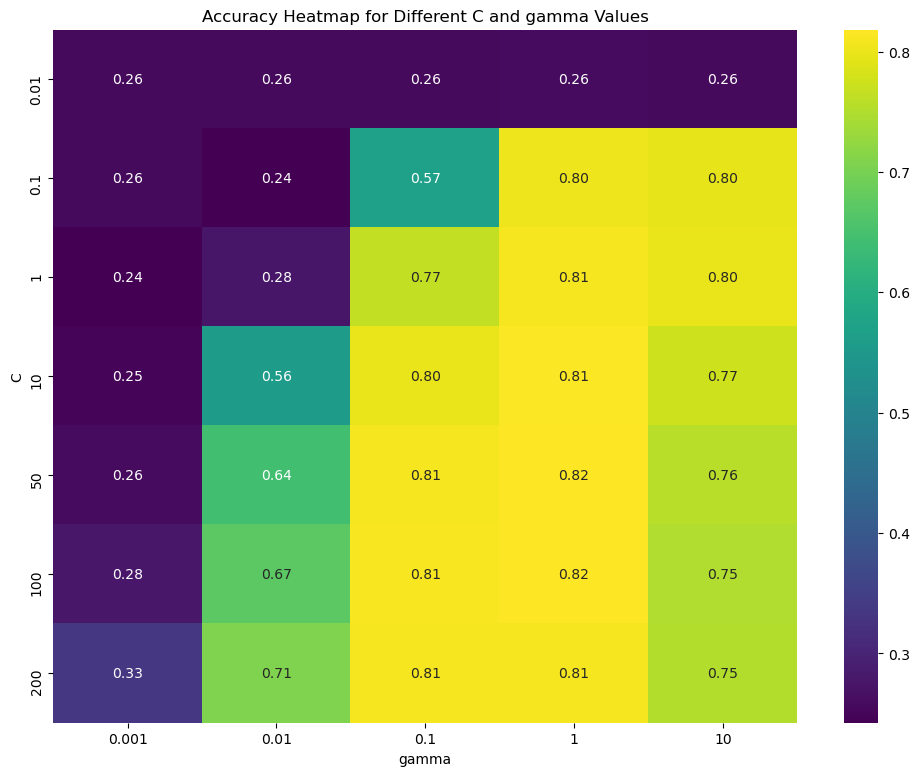

Best C value: 100
Best gamma value: 1
Confusion Matrix:
[[74 10  0 18]
 [ 8 90 11  1]
 [ 4  7 82  6]
 [ 8  2 17 62]]


In [13]:
#Imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Define the range of hyperparameter values to explore
C_values = [0.01, 0.1, 1, 10, 50, 100, 200]
gamma_values = [0.001, 0.01, 0.1, 1, 10]

# Create an SVM classifier object
svm = SVC()

# Define the parameter grid for grid search
param_grid = {'C': C_values, 'gamma': gamma_values}

# Create a GridSearchCV object with the desired scoring metric
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the results of the grid search
results = grid_search.cv_results_

# Extract the mean accuracy values for each combination of hyperparameters
mean_accuracy = results['mean_test_score']

# Reshape the mean accuracy array to match the shape of the heatmap
mean_accuracy_grid = mean_accuracy.reshape(len(C_values), len(gamma_values))

# Create a heatmap to display accuracy according to different hyperparameter values
plt.figure(figsize=(12, 9))
sns.heatmap(mean_accuracy_grid, annot=True, fmt='.2f', cmap='viridis', cbar=True,
            xticklabels=gamma_values, yticklabels=C_values)
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('Accuracy Heatmap for Different C and gamma Values')
plt.show()

# Get the best hyperparameter values
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']
print("Best C value:", best_C)
print("Best gamma value:", best_gamma)

# Retrain the SVM classifier with the best hyperparameter values
svm_best = SVC(C=best_C, gamma=best_gamma)
svm_best.fit(X_train, y_train)

# Make predictions on the test dataset with the best model
test_predictions = svm_best.predict(X_test)

# Calculate the confusion matrix on the test dataset
confusion_matrix = metrics.confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(confusion_matrix)

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Amb el dataset de _train_, entreneu un model de SVM amb la millor combinació de paràmetres trobada.

- Calculeu el _accuracy_ del model obtingut sobre _train_ i _test_.

- Calculeu la matriu de confusió sobre _test_.
    
- Representeu gràficament la frontera de decisió amb el conjunt de _test_.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

Best C and gamma values: 100 1
Train Accuracy: 0.84875
Test Accuracy: 0.77
Confusion Matrix:
[[74 10  0 18]
 [ 8 90 11  1]
 [ 4  7 82  6]
 [ 8  2 17 62]]


Text(0.5, 1.0, 'SVMClassifier C=100 and gamma=1')

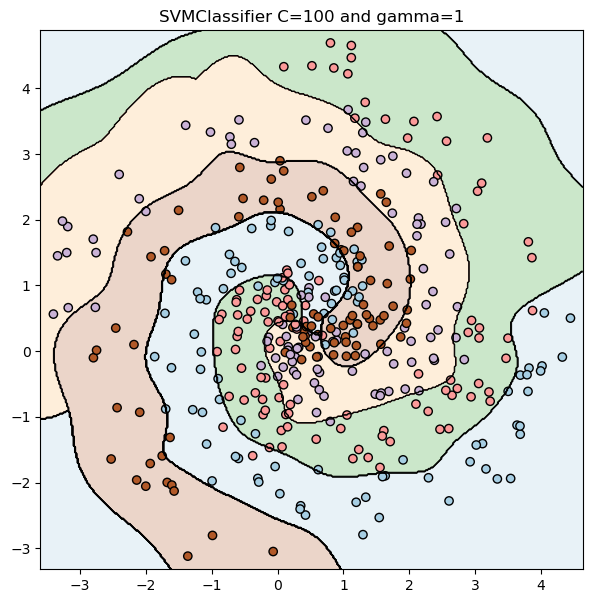

In [14]:
#Imports
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics

print("Best C and gamma values:", best_C, best_gamma)

# Train an SVM classifier with the best hyperparameter values
svm_best = SVC(C=best_C, gamma=best_gamma)
svm_best.fit(X_train, y_train)

# Make predictions on the train dataset
train_predictions = svm_best.predict(X_train)

# Calculate the accuracy on the train dataset
train_accuracy = metrics.accuracy_score(y_train, train_predictions)
print("Train Accuracy:", train_accuracy)

# Make predictions on the test dataset
test_predictions = svm_best.predict(X_test)

# Calculate the accuracy on the test dataset
test_accuracy = metrics.accuracy_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)

# Calculate the confusion matrix on the test dataset
confusion_matrix = metrics.confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(confusion_matrix)

# Plot the decision boundary on the test dataset
plot_decision_boundary(svm_best, X_test, y_test)
plt.title(f"SVMClassifier C={best_C} and gamma={best_gamma}".format(best_C=best_C, best_gamma=best_gamma))


<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

- Comentar els resultats de la cerca dels millors hiperparàmetres.
- Com són les fronteres de decisió? Té sentit que tinguin aquesta forma amb l'algoritme utilitzat?
- Com són les prediccions obtingudes sobre el conjunt de test?
</div>

Els límits d'un classificador del tipus Support Vector Machine (SVM) es defineixen pels hiperplans que separen maximalment les diferents classes en l'espai de característiques. Els algorismes SVM poden treballar amb dades linealment separables i no linealment separables. En el cas de les dades linealment separables, el límit de decisió és un hiperplà que separa netament les dues classes. Per a les dades no linealment separables, els SVMs empren l'ús de funcions kernel que transformen l'espai de característiques original en un espai de dimensió superior on els punts de dades es tornen més separables. En l'espai transformat, l'algorisme SVM pot trobar un hiperplà que separa les classes. El límit de decisió en aquest espai de dimensió superior correspon a un límit no lineal en l'espai de característiques original.
L'elecció de les funcions kernel, així com els diferents hiperparàmetres que les componen, tenen un pes fonamental que pot influir en la forma i la flexibilitat de la frontera de decisió. Per a calcular els valors òptims dels hiperparàmetres _C_ i _gama_, hem realitzat una combinació d'hiperparàmetres possibles i hem avaluat la precisió del model mitjançant la validació creuada. Hem escollit la combinació d'hiperparàmetres que donen una precisió major al model; en aquest cas correspon a _C_ = 100 i _gama_ = 1.
Finalment, observant els límits de decisió corresponents a la representació gràfica amb el conjunt de test, veiem que les prediccions de la classificació duta a terme generen unes fronteres bastant encertades a les distribucions de les diferents classes. A la vegada, podem veure que la precisió de classificació del model SVM disposa d'una precisió bastant alta.

<div class="alert alert-block alert-success">
<strong>Resposta:</strong> 


</div>

## 1.5. Arbres de decisió

Els arbres de decisió són models predictius formats per regles binàries (si/no) amb què s'aconsegueix repartir les observacions en funció dels seus atributs i predir el valor de la variable resposta.

Els arbres poden ser **classificadors** (per classificar classes, tals com el nostre exemple), o bé **regressors** (per predir variables contínues).

#### Construcció d´un arbre

La creació de les ramificacions dels arbres s'aconsegueix mitjançant l'algorisme de *recursive binary splitting*. Aquest algorisme consta de tres passos principals:

- El procés s'inicia a dalt de tot de l'arbre, on totes les observacions pertanyen a la mateixa regió.
- S'identifiquen tots els possibles punts de tall per a cadascun dels predictors. Els punts de tall són cadascun dels nivells.
- S'avaluen les possibles divisions de cada predictor d'acord amb una mesura determinada. En el cas dels classificadors s'utilitzen: *classification error rate*, Gini, entropia, txi-square.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Amb el dataset de _train_, entreneu un arbre de decisió. Podeu utilitzar el classificador `DecisionTreeClassifier` (de `tree` de `sklearn`).

- Calculeu el _accuracy_ del model obtingut sobre _train_ i _test_.

- Calculeu la matriu de confusió sobre _test_.
    
- Representeu gràficament la frontera de decisió amb el conjunt de _test_.
    
- Representeu l'arbre. Podeu utilitzar la comanda `plot.tree` de la biblioteca `tree` de `sklearn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

Train Accuracy: 1.0
Test Accuracy: 0.7175
Confusion Matrix:
[[71 16  2 13]
 [10 84 13  3]
 [ 4 13 72 10]
 [11  2 16 60]]


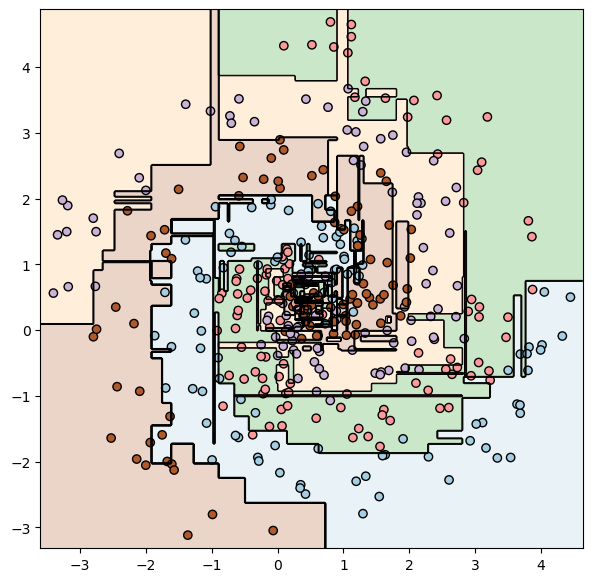

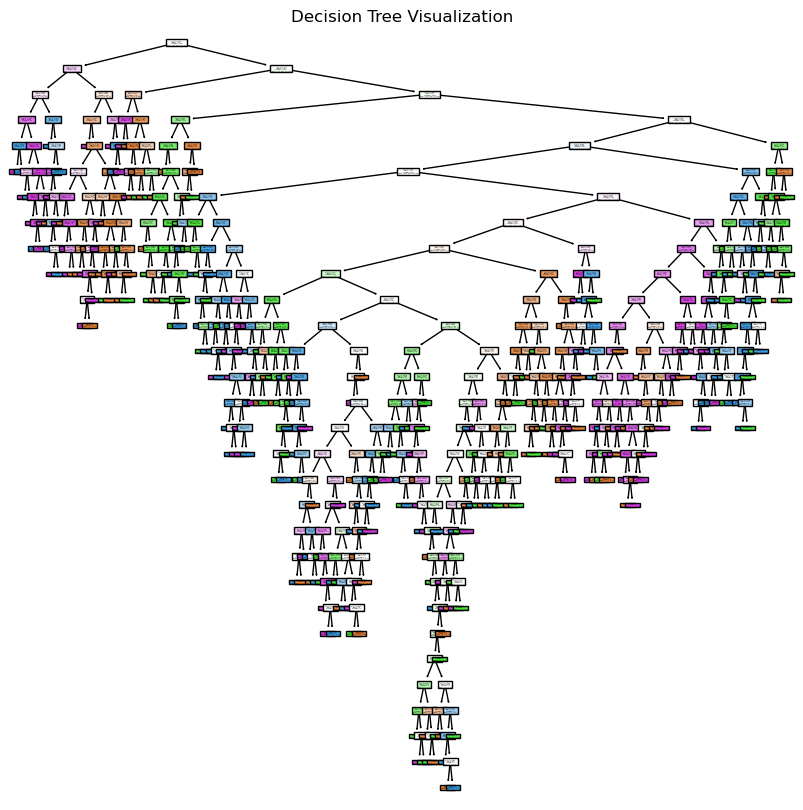

In [15]:
#Imports
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn import tree

# Train a decision tree classifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

# Make predictions on the train dataset
train_predictions = decision_tree.predict(X_train)

# Calculate the accuracy on the train dataset
train_accuracy = metrics.accuracy_score(y_train, train_predictions)
print("Train Accuracy:", train_accuracy)

# Make predictions on the test dataset
test_predictions = decision_tree.predict(X_test)

# Calculate the accuracy on the test dataset
test_accuracy = metrics.accuracy_score(y_test, test_predictions)
print("Test Accuracy:", test_accuracy)

# Calculate the confusion matrix on the test dataset
confusion_matrix = metrics.confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(confusion_matrix)

# Plot the decision boundary on the test dataset
plot_decision_boundary(decision_tree, X_test, y_test)

# Visualize the decision tree
plt.figure(figsize=(10, 10))
tree.plot_tree(decision_tree, filled=True)
plt.title('Decision Tree Visualization')
plt.show()


<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

- Comenteu els resultats.

</div>

Les fronteres generades pel classificador d'arbre de decisió estan formades per una seqüència de línies rectes (horitzontals i verticals), generant una representació molt estranya i complex d'interpretar. Observem regions que es troben dins d'altres regions que no inclouen cap punt. A la vegada, si analitzem l'arbre de decisió resultant, veiem que es tracta d'un arbre molt gran, amb moltes subdivisions. Aquest fet ens pot portar a pensar que estem davant d'un arbre sobreentrenat; cosa que es confirma quan veiem la precisió del model amb el conjunt d'entrenament, respecte al conjunt de test.

<div class="alert alert-block alert-success">
<strong>Resposta:</strong> 


</div>

#### Evitant el *overfitting*

El procés de construcció d'arbres descrit tendeix a reduir ràpidament l'error d'entrenament, per la qual cosa generalment el model s'ajusta molt bé a les observacions utilitzades com a entrenament (conjunt de train). Com a conseqüència, els arbres de decisió tendeixen al *overfitting*.

Per prevenir-ho, utilitzarem dos hiperparàmetres:

- `max_depth`: la profunditat màxima de l'arbre. Explorarem els valors entre 4 i 10.
- `min_samples_split`: el nombre mínim d'observacions que ha de tenir un full de l'arbre per poder dividir-lo. Explorarem els valors: 2, 10, 20, 50 i 100.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Calculeu el valor òptim dels hiperparàmetres `max_depth` i `min_samples_split`. Utilitzeu una cerca de reixeta amb validació creuada per trobar els valors òptims. Per a cada combinació de valors, calculeu la seva mitjana i la desviació estàndard. Feu un _heatmap_ per visualitzar la precisió segons els diferents valors dels hiperparàmetres.
    
Podeu utilitzar el mòdul `GridSearchCV` de `sklearn` pel càlcul dels millors hiperparàmetres amb el classificador `DecisionTreeClassifier` (de `tree` de `sklearn`), i `heatmap` de `Seaborn`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

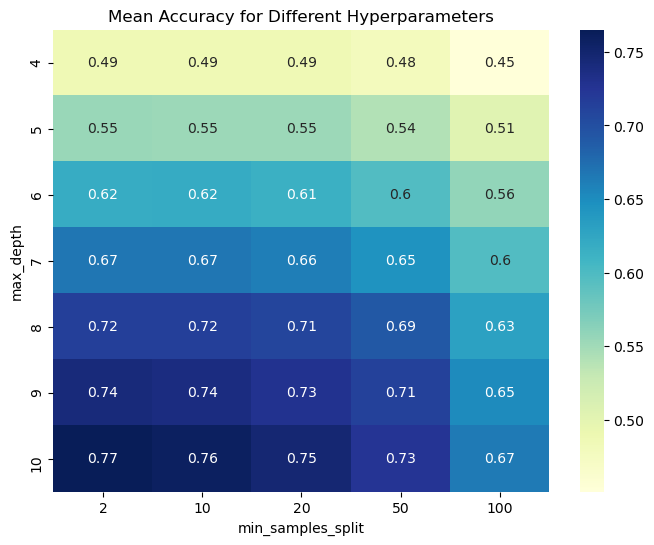

Best Hyperparameters:
{'max_depth': 10, 'min_samples_split': 2}
Best Mean Accuracy: 0.765


In [16]:
#Imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create a decision tree classifier
decision_tree = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'max_depth': range(4, 11),
    'min_samples_split': [2, 10, 20, 50, 100]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the results as a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Create a heatmap of the mean accuracy values
accuracy_heatmap = results.pivot("param_max_depth", "param_min_samples_split", "mean_test_score")
plt.figure(figsize=(8, 6))
sns.heatmap(accuracy_heatmap, annot=True, cmap="YlGnBu")
plt.title("Mean Accuracy for Different Hyperparameters")
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.show()

# Print the best hyperparameters and their corresponding mean accuracy
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Hyperparameters:")
print(best_params)
print("Best Mean Accuracy:", best_score)

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Amb el dataset de _train_, entreneu un arbre de decisió amb la millor combinació de paràmetres trobada.

- Calculeu el _accuracy_ del model obtingut sobre _train_ i _test_.

- Calculeu la matriu de confusió sobre _test_.
    
- Representeu gràficament la frontera de decisió amb el conjunt de _test_.
    
- Representeu l'arbre.
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

Best Hyperparameters:
{'max_depth': 10, 'min_samples_split': 2}


<Figure size 800x600 with 0 Axes>

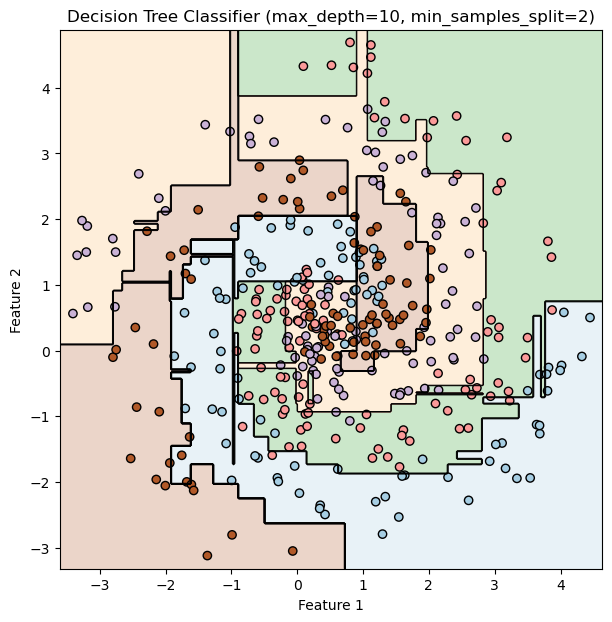

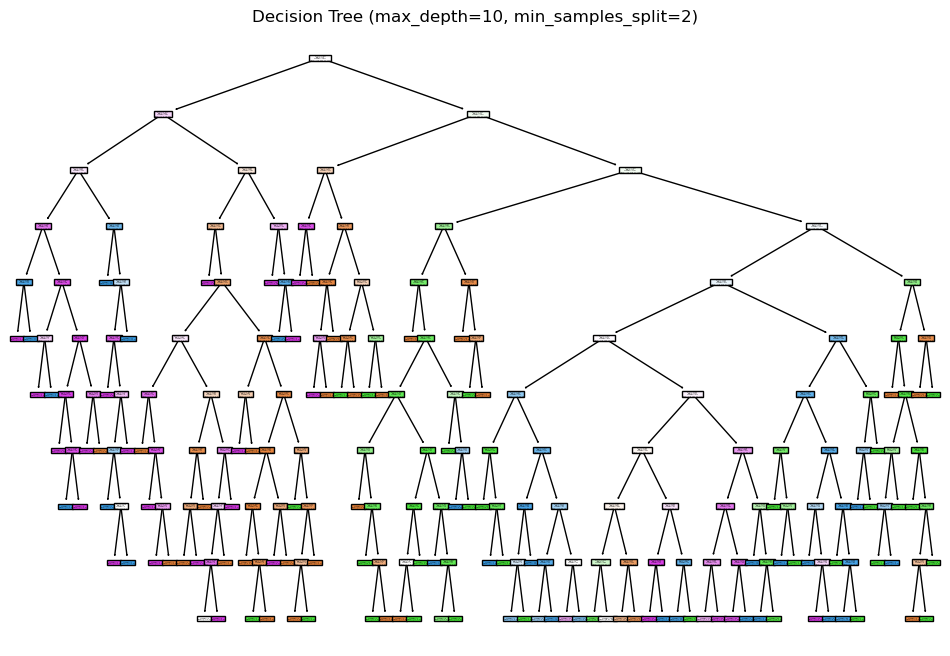

Train Accuracy: 0.854375
Test Accuracy: 0.7
Confusion Matrix:
[[66 10 10 16]
 [ 9 71 30  0]
 [ 0  7 85  7]
 [ 7  0 24 58]]


In [18]:
#Imports
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

print("Best Hyperparameters:")
print(best_params)

# Train a decision tree classifier with the best hyperparameters
best_params = grid_search.best_params_
decision_tree = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'])
decision_tree.fit(X_train, y_train)

# Make predictions on the train and test datasets
y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

# Calculate the accuracy of the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_test_pred)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plot_decision_boundary(decision_tree, X_test, y_test)
plt.title(f"Decision Tree Classifier (max_depth={best_params['max_depth']}, min_samples_split={best_params['min_samples_split']})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree, filled=True)
plt.title(f"Decision Tree (max_depth={best_params['max_depth']}, min_samples_split={best_params['min_samples_split']})")
plt.show()

# Print the accuracy and confusion matrix
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:")
print(confusion_mat)


<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

- Comentar els resultats de la cerca dels millors hiperparàmetres.
- Com són les fronteres de decisió? Té sentit que tinguin aquesta forma amb l'algoritme utilitzat?
- Com són les prediccions obtingudes sobre el conjunt de test?
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong> 


</div>

Els límits d'un classificador model d'arbre de decisió es defineixen per una sèrie de decisions binàries preses a cada node de l'arbre. Cada decisió divideix l'espai de característiques en regions més petites o subespais, el que condueix a la formació de límits de decisió. Un algorisme de tipus arbre de decisió divideix recursivament l'espai de característiques en funció dels valors de les característiques d'entrada. A cada un dels nodes interns, es pren una decisió basada en una característica específica i un valor llindar; és aquesta decisió la que determina sobre quina branca seguir, creant d'aquesta manera noves divisions de l'espai de característiques. Les fronteres de decisió que trobem en un model de tipus arbre de decisió són eixos paral·lels i alineats amb els eixos de característiques, poden capturar relacions no lineals i adaptar-se a diferents patrons de les dades. La profunditat i complexitat de l'arbre de decisions influeixen en la forma i granularitat dels límits de decisió.

Per calcular els valors òptims dels hiperparàmetres _max_depth_ i _min_samples_split_ hem realitzat una combinació d'hiperparàmetres possibles i hem avaluat la precisió del model mitjançant la validació creuada. Hem escollit la combinació d'hiperparàmetres que donen una precisió major al model; en aquest cas correspon a _max_depth_ = 10 i _min_samples_split_= 2. Finalment, observant els límits obtinguts corresponents a la representació gràfica amb el conjunt de test, veiem que les prediccions de la classificació duta a terme generen unes fronteres amb moltes línies rectes (tant verticals com horitzontals) que divideixen l'espai de característiques en regions més petites o subespais. En aquest cas, respecte a l'anteriorment analitzat, veiem un arbre de decisió molt més reduït i que aparenta una classificació més balancejada i generalitzada. Aquest fet pren més força, ja que el valor de la precisió amb el conjunt d'entrenament no pren un valor d'1 i es manté amb el conjunt de test.

<a id='ej2'></a>
# 2. Implementació del cas pràctic (5 punts)

Com a expert en anàlisi de dades, sabem la importància que les empreses de targetes de crèdit puguin identificar i prevenir transaccions fraudulentes per protegir els seus clients. En aquest sentit, estudiarem un conjunt de dades que conté informació sobre transaccions realitzades amb targetes de crèdit el setembre del 2013 per titulars de targetes europeus.

Aquest conjunt de dades presenta transaccions efectuades en dos dies, on s'han registrat 492 casos de frau d'un total de 284.807 transaccions. És important destacar que totes les variables d'entrada són numèriques i van ser obtingudes a través d'una transformació PCA. Lamentablement, per raons de confidencialitat, no es poden proporcionar les característiques originals, ni més informació sobre les dades. 

Les variables V1 a V28 representen els components principals obtinguts amb PCA, mentre que “Time” i “Amount” són les úniques variables que no han estat transformades amb PCA. La variable "Time" indica els segons transcorreguts entre cada transacció i la primera transacció del conjunt de dades, mentre que "Amount" representa la suma de la transacció. La variable “Class” és la variable de resposta i pren el valor 1 en cas de frau i 0 en cas contrari.

Font: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

## 2.0. Càrrega de dades

El primer que farem serà carregar el conjunt de dades, visualitzar les primeres files i verificar:

- La quantitat total de files i columnes al DataFrame.
- El nom de cada columna del DataFrame.
- El nombre de valors no nuls a cada columna.
- El tipus de dades de cada columna, que poden ser int, float, object, entre d'altres.
- La quantitat de memòria utilitzada pel DataFrame.

In [19]:
import numpy as np 
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
data = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 2.1. Preprocessament de dades i anàlisi exploratòria

El preprocessament i l'anàlisi exploratòria de les dades és un pas crític i fonamental en qualsevol projecte d'anàlisi de dades o d'aprenentatge automàtic. Ajuda als investigadors a comprendre millor les dades, descobrir patrons i relacions, identificar problemes i seleccionar les tècniques d'anàlisi adequades per al conjunt de dades

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

Calculeu les freqüències de la variable _target_ (`Class`) i feu un gràfic de barres.

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

### Grafis

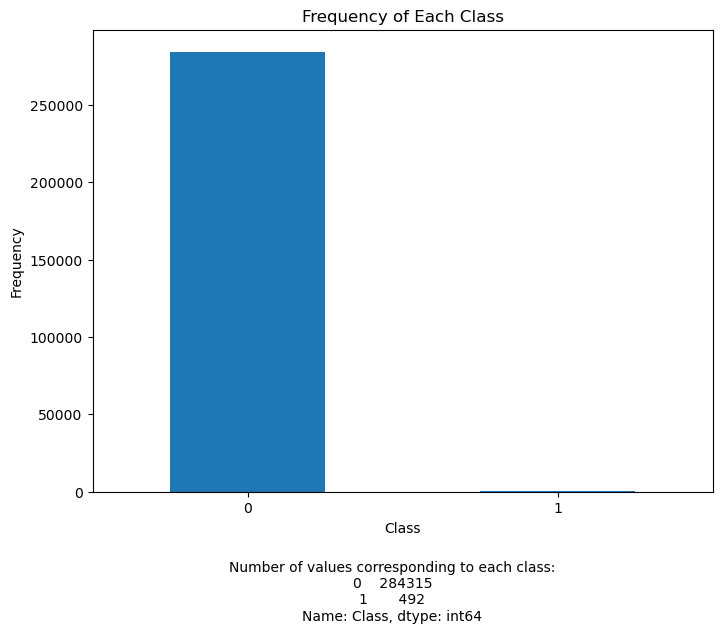

In [22]:
# Calculate the frequencies of the 'Class' variable
class_counts = data['Class'].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Class')
plt.xticks(rotation=0)

# Add a caption
caption = "Number of values corresponding to each class:\n" + str(class_counts)
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center')

# Show the plot
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

Analitzar la distribució de les variables descriptores. Representa gràficament l'histograma de les 30 variables separant les observacions segons la classe a què pertany. Organitza tots els histogrames a 10 files i 3 columnes.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

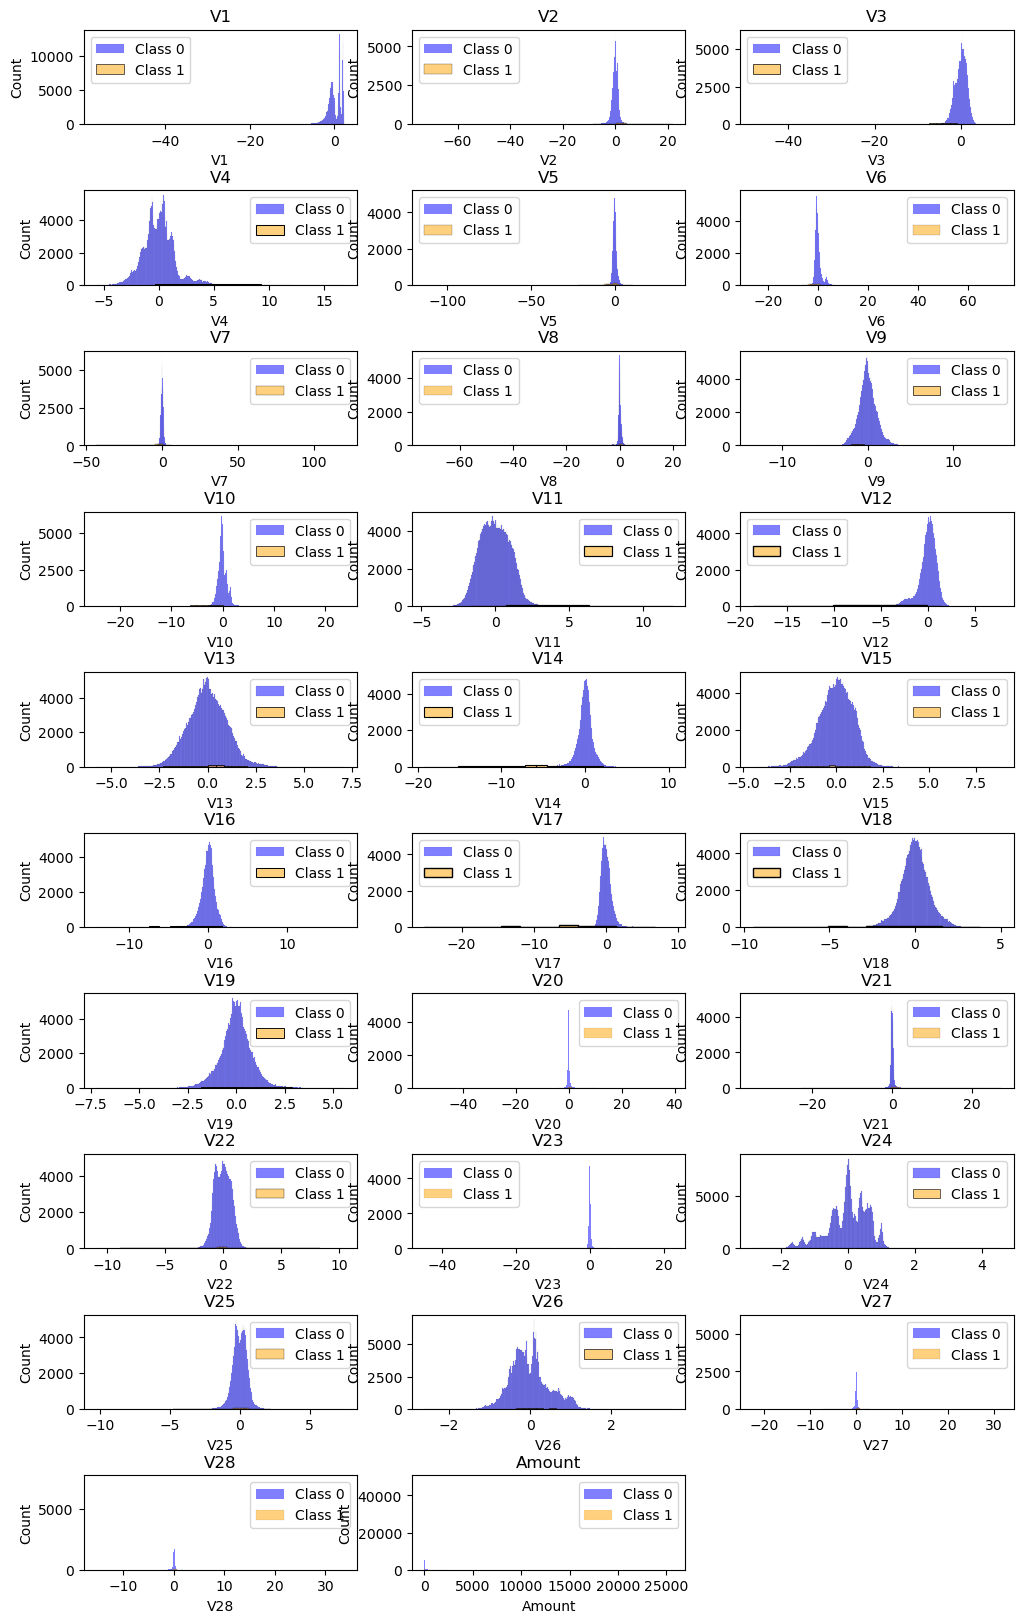

In [23]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Separate the data by class
class_0_data = data[data['Class'] == 0]
class_1_data = data[data['Class'] == 1]

# Select the descriptor variables
descriptor_columns = data.columns[1:-1]  # Exclude 'Time' and 'Class' columns

# Create subplots
num_rows = 10
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))
fig.subplots_adjust(hspace=0.7)  # Increase the value to add more separation

# Plot histograms for each descriptor variable
for i, column in enumerate(descriptor_columns):
    row = i // num_cols
    col = i % num_cols

    ax = axes[row, col]
    sns.histplot(class_0_data[column], ax=ax, label='Class 0', color='blue', alpha=0.5)
    sns.histplot(class_1_data[column], ax=ax, label='Class 1', color='orange', alpha=0.5)

    ax.set_title(column)
    ax.legend()

# Remove empty subplots if the number of descriptor variables is not a multiple of 3
if len(descriptor_columns) % num_cols != 0:
    for i in range(len(descriptor_columns) % num_cols, num_cols):
        fig.delaxes(axes[-1, i])

# Show the plot
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

- Com és la relació de les freqüències de la variable `Class`?
- Quina informació ens proporcionen els histogrames? Hi ha una altra forma de visualització que pogués ser útil, en aquest cas?
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong> 


</div>

Visualitzant l'histograma de les freqüències en funció de la variable 'Class', podem afirmar de forma rotunda que la quantitat de registres que pertanyen a la 'Class' amb valor 1 són absolutament minoritaris respecte a les quals pertanyen a la Class=0.

### Data

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Les dades en brut presenten alguns problemes. En primer lloc, les columnes `Time` i `Amount` són massa variables per utilitzar-les directament. Elimineu la columna `Time` (ja que no és clar què significa) i preneu el logaritme de la columna `Amount` per reduir el seu rang.
    
Per evitar la indeterminació "log(0)", sumeu-li 1 cèntim de dolar (0.001) a la columna `Amount` abans de calcular el logaritme. No oblideu que finalment heu de reemplaçar la columna `Amount` per `Log Amount`
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

In [24]:
#Imports
import pandas as pd
import numpy as np

# Remove the 'Time' column
data.drop('Time', axis=1, inplace=True)

# Take the logarithm of 'Amount' column and add 0.001
data['Log Amount'] = np.log(data['Amount'] + 0.001)

# Drop the original 'Amount' column
data.drop('Amount', axis=1, inplace=True)

# Verify the updated DataFrame
print(data.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.098698  0.363787  0.090794  ... -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  0.753074  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Class  Log Amount  
0  0.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Separeu els descriptors de la resposta. Anomeneu els conjunts com: X, y.

- Dividiu el _dataset_ en dos subconjunts, __*train*__ (80% de les dades) i __*test*__ (20% de les dades). Anomeneu els conjunts com: X_train, X_test, y_train, y_test. Podeu utilitzar la funció `train_test_split` de la biblioteca `model_selection` de `sklearn`. Utilitzeu l'opció `random_state = 24` i assegureu-vos que la divisió sigui estratificada, és a dir, que es mantingui la mateixa proporció de classes tant en el conjunt d'entrenament com en el conjunt de test.

Tingueu en compte que les matrius de les classes `y_train` i `y_test` han d'estar codificades. La funció `to_categorical` de la llibreria `TensorFlow` de `Keras` s'utilitza per convertir una matriu d'etiquetes de classe (sencers) en una matriu d'etiquetes de classe codificades en _one-hot_.

La codificació _one-hot_ és un procés mitjançant el qual les etiquetes categòriques es converteixen en vectors binaris on cada vector té una longitud igual al nombre de classes. Cada vector té un valor d'1 a la posició corresponent a la classe i un valor de 0 a totes les altres posicions. Això es fa per permetre que els models d'aprenentatge automàtic comprenguin millor l'estructura de les etiquetes categòriques.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

In [25]:
#Imports
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import to_categorical
# from tensorflow.keras.utils import to_categorical

# Separate descriptors (X) from the target variable (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Convert target variable to one-hot encoded array
y = to_categorical(y)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=24)

# Verify the shapes of the datasets
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (227845, 29)
y_train shape: (227845, 2)
X_test shape: (56962, 29)
y_test shape: (56962, 2)


<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Normalitzeu els descriptors utilitzant `StandardScaler` de `sklearn`.
- Mostreu les dimensions del conjunt de descriptors original, del conjunt d'entrenament i del conjunt de test.
    
<strong>Nota:</strong> Recordeu que el `StandardScaler` només s'ajusta utilitzant els descriptors d'entrenament per evitar fuites d'informació o "data leakage". La fuita d'informació es produeix quan es fa servir informació de les dades de test o validació per ajustar el model. En altres paraules, si s'ajusta el model d'escalat amb tot el conjunt de dades, s'utilitzaria informació de test o validació per a l'ajust, cosa que podria fer que el model sembli més precís del que realment és.

</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

In [26]:
#Imports
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training descriptors and transform them
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test descriptors using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Print the dimensions of the original set of descriptors, training set, and test set
print("Original descriptors shape:", X.shape)
print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Original descriptors shape: (284807, 29)
Training set shape: (227845, 29)
Test set shape: (56962, 29)


## 2.2. Entrenament, validació i prova d'una xarxa neuronal amb les dades originals

Com a eina de classificació que ens permeti predir si una transacció és fraudulenta o no, farem servir un perceptró multicapa. 

Un perceptró multicapa (MLP, per les sigles en anglès) és una xarxa neuronal artificial composta per múltiples capes d'unitats de processament (neurones), on cada capa està connectada a la següent capa a través d'un conjunt de connexions ponderades. El MLP és capaç de realitzar tant tasques de classificació com de regressió, en aprendre a mapejar les entrades a les sortides desitjades mitjançant una funció d'activació no lineal. 

La xarxa utilitza un algoritme d'aprenentatge supervisat que ajusta els pesos de les connexions durant l'entrenament per minimitzar la diferència entre les sortides produïdes per la xarxa i les sortides desitjades. A causa de la seva capacitat per modelar relacions no lineals complexes, el MLP és un dels models més utilitzats al camp de l'aprenentatge automàtic.

Crearem i entrenarem una xarxa Perceptró Multicapa (MLP) amb 4 capes ocultes de 20 neurones cadascuna i amb funció dʻactivació `relu`. Farem servir la classe `Sequential` de la llibreria `keras` per crear el model de forma seqüencial, és a dir, apilant capes una damunt de l'altra. Sequential és la forma més senzilla de crear models de xarxes neuronals en keras, ja que no requereix definir la direcció del graf computacional com passa en altres tipus de models més complexos.


<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Creeu el model `Sequential`. Afegiu les 4 capes ocultes amb 20 neurones cadascuna utilitzant el mètode `.add()` i funció d'activació `relu`. Afegiu la capa de sortida amb 2 neurones de sortida (una per a la classe 0 i l'altra per a la classe 1) i funció d'activació `sigmoid`. Mostreu el resum de la xarxa creada amb el mètode `.summary()`
- Compileu el model utilitzant el mètode `.compile()`, especificant l'optimitzador `adam`, la funció de pèrdua `binary_crossentropy` i les mètrica d'avaluació `accuracy`.
- Entreneu el model utilitzant el mètode `.fit()` amb `X_train`, especifiqueu el nombre d'èpoques en 100 i la mida del lot el 2048. Valideu el vostre rendiment fent validació creuada amb el 80% de les dades per a l'entrenament. Configura el paràmetre `validation_split=0.2`.
- Grafiqueu la pèrdua (`loss`) tant d'entrenament com de validació en funció de les èpoques.
- Grafiqueu l'exactitud (`accuracy`) tant d'entrenament com de validació en funció de les èpoques.
    
<strong>Nota:</strong> Per a la presentació de l'informe, configureu el paràmetre `verbose=0`, per evitar mostrar informació durant l'entrenament.
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hl1 (Dense)                 (None, 20)                600       
                                                                 
 hl2 (Dense)                 (None, 20)                420       
                                                                 
 hl3 (Dense)                 (None, 20)                420       
                                                                 
 hl4 (Dense)                 (None, 20)                420       
                                                                 
 al_sigmoid (Dense)          (None, 2)                 42        
                                                                 
Total params: 1,902
Trainable params: 1,902
Non-trainable params: 0
_________________________________________________________________


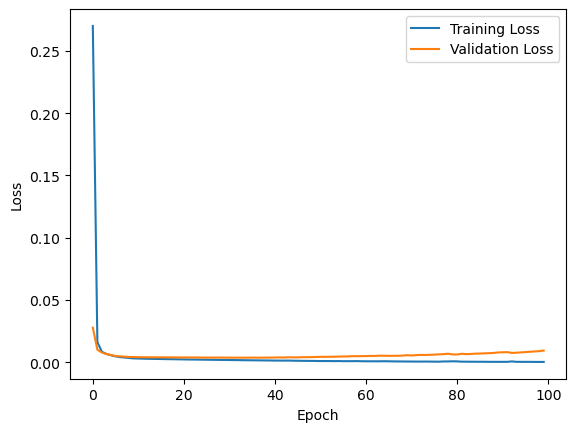

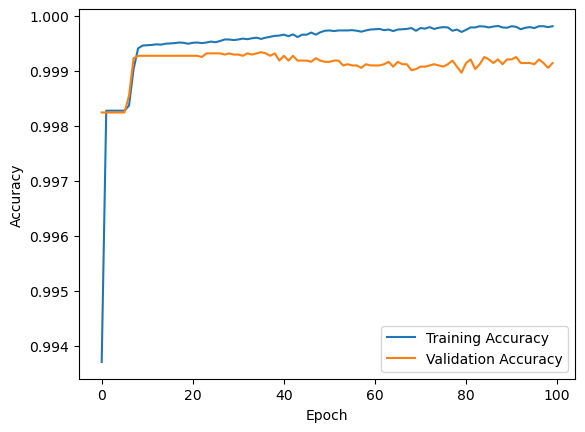

In [27]:
#Imports
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

# Create the Sequential model
model = Sequential(name="MLP")

# Add the hidden layers with 20 neurons and relu activation
model.add(Dense(20, activation='relu', input_shape=(X_train.shape[1],), name="hl1"))
model.add(Dense(20, activation='relu', name="hl2"))
model.add(Dense(20, activation='relu',name="hl3"))
model.add(Dense(20, activation='relu', name="hl4"))

# Add the output layer with 2 neurons and sigmoid activation
model.add(Dense(2, activation='sigmoid', name="al_sigmoid"))

# Build the model
model.build()

# Display the network summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=24)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=2048, validation_data=(X_val, y_val), verbose=0)

# Graph the loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graph the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Un cop entrenat i validat el model, procedirem a fer la prova, és a dir, predir la classe de `X_test` i calcular les mesures de rendiment.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Prediu la classe de `X_test`, calculeu l'exacitud de la predicció.
- Calculeu la matriu de confusió
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

In [28]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Convert one-hot encoded true labels to binary format
y_test_binary = np.argmax(y_test, axis=1)

# Predict class labels for test data
y_pred = model.predict(X_test)
y_pred_binary = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print("Accuracy:", accuracy)

# Calculate confusion matrix
confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)
print("Confusion Matrix:")
print(confusion_matrix)

1781/1781 [==============================] - 1s 783us/step
Accuracy: 0.9992099996488887
Confusion Matrix:
[[56850    14]
 [   31    67]]


<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

- Què opines dels resultats?, ens podem quedar amb aquest model com a acceptable?
- **Les mesures de rendiment usades són acceptables?** Quina altra mesura de rendiment proposaries?
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong> 


</div>

Visualitzant els resultats obtinguts, tant les mesures de rendiment com en la validació del model, podem observar una precisió molt alta. Que els valors aconseguits siguin tan alts i que pràcticament hi arribem amb les primeres 20 iteracions, ens porta a pensar que ens trobem en un cas clar de sobreentrenament, on la xarxa s'està adaptant al conjunt de dades d'entrenament perdent la capacitat de poder generalitzar.

## 2.3. Submostreig

El submostreig fa referència a la tècnica de reduir el nombre de mostres de la classe majoritària per equilibrar la distribució de classes en un conjunt de dades. Això es pot aconseguir eliminant aleatòriament mostres de la classe majoritària.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Redueix el nombre d'observacions de la classe majoritària del conjunt de dades _X_train_ fins que tingui el mateix nombre d'observacions que la classe minoritària. Mostra les dimensions de les noves matrius d'entrenament i la freqüència de cada classe. Podeu utilitzar la fució `resample` de la bibioteca `utils` de `sklearn`.
- Creeu, entreneu, grafiqueu les pèrdues i exactitud durant l'entrenament, valideu i proveu un altre model Sequential amb la mateixa configuració de l'apartat anterior.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

In [ ]:
#Imports
from sklearn.utils import resample
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score

# Concatenate X_train and y_train
train_data = np.concatenate((X_train, y_train), axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data[:, -1] == 0]
minority_class = train_data[train_data[:, -1] == 1]

# Downsample the majority class to match the number of observations in the minority class
majority_downsampled = resample(majority_class,
                                replace=False,
                                n_samples=len(minority_class),
                                random_state=42)

# Combine the downsampled majority class with the minority class
balanced_train_data = np.concatenate((majority_downsampled, minority_class), axis=0)

# Separate the features (X) and labels (y) from the balanced training data
X_train_balanced = balanced_train_data[:, :-1]
y_train_balanced = balanced_train_data[:, -1]

# Display dimensions of the new training matrices
print("Dimensions of the balanced training data:")
print("X_train_balanced:", X_train_balanced.shape)
print("y_train_balanced:", y_train_balanced.shape)

# Display frequency of each class
unique, counts = np.unique(y_train_balanced, return_counts=True)
class_frequencies = dict(zip(unique, counts))
print("Class frequencies in the balanced training data:")
print(class_frequencies)

Dimensions of the balanced training data:
X_train_balanced: (628, 30)
y_train_balanced: (628,)
Class frequencies in the balanced training data:
{0.0: 314, 1.0: 314}


In [ ]:

# Create the Sequential balanced model
model_balanced = Sequential(name="Balanced MLP Model")
model_balanced.add(Dense(20, activation='relu', input_shape=(30,), name="hl1"))
model_balanced.add(Dense(20, activation='relu', name="hl2"))
model_balanced.add(Dense(20, activation='relu', name="hl3"))
model_balanced.add(Dense(20, activation='relu', name="hl4"))
model_balanced.add(Dense(2, activation='sigmoid', name="al_sigmoid"))

# Build the model
model_balanced.build(input_shape=(None, 30))

# Display the network summary
model_balanced.summary()

# Compile the model
model_balanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split the training data for validation
X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced = train_test_split(y_train_balanced, y_train_balanced, test_size=0.2, random_state=24)

# Wrap the code inside a 'with tf.device('/CPU:0'):' block
with tf.device('/CPU:0'):
    # Train the model
    history = model_balanced.fit(X_train_balanced, y_train_balanced, epochs=100, batch_size=2048, validation_data=(X_val_balanced, y_val_balanced), verbose=0)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

- Per què creus que s'ha fet un remostreig només a les dades d'entrenament?
- Què opines dels resultats? Ens podem quedar amb aquest model com a acceptable?
    
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong> 


</div>

## 2.4. Sobremostreig

Al contrari que el cas anterior, el sobremostreig fa referència a la tècnica d'augmentar el nombre de mostres de la classe minoritària per equilibrar la distribució de classes en un conjunt de dades. Això es pot aconseguir mitjançant la replicació de mostres existents o mitjançant la generació de mostres sintètiques de les classes minoritàries.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Augmenta el nombre d'observacions de la classe minoritària del conjunt de dades _X_train_ fins que tingui el mateix nombre d'observacions que la classe majoritària. Mostra les dimensions de les noves matrius d'entrenament i la freqüència de cada classe.
- Creeu, entreneu i grafiqueu les pèrdues i exactitud durant l'entrenament, valitadeu i proveu un altre model Sequential amb la mateixa configuració de l'apartat anterior.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

In [ ]:
from sklearn.utils import resample

# Concatenate X_train and y_train
train_data = np.concatenate((X_train, y_train), axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data[:, -1] == 0]
minority_class = train_data[train_data[:, -1] == 1]

# Upsample the minority class to match the number of observations in the majority class
minority_upsampled = resample(minority_class,
                              replace=True,
                              n_samples=len(majority_class),
                              random_state=42)

# Combine the upsampled minority class with the majority class
balanced_train_data = np.concatenate((majority_class, minority_upsampled), axis=0)

# Separate the features (X) and labels (y) from the balanced training data
X_train_balanced = balanced_train_data[:, :-1]
y_train_balanced = balanced_train_data[:, -1]

# Display dimensions of the new training matrices
print("Dimensions of the balanced training data:")
print("X_train_balanced:", X_train_balanced.shape)
print("y_train_balanced:", y_train_balanced.shape)

# Display frequency of each class
unique, counts = np.unique(y_train_balanced, return_counts=True)
class_frequencies = dict(zip(unique, counts))
print("Class frequencies in the balanced training data:")
print(class_frequencies)

Dimensions of the balanced training data:
X_train_balanced: (363924, 30)
y_train_balanced: (363924,)
Class frequencies in the balanced training data:
{0.0: 181962, 1.0: 181962}


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Create the Sequential model
model_oversample = Sequential(name="Oversampling MLP Model")
model_oversample.add(Dense(20, activation='relu', input_shape=(30,), name="hl1"))
model_oversample.add(Dense(20, activation='relu', name="hl2"))
model_oversample.add(Dense(20, activation='relu', name="hl3"))
model_oversample.add(Dense(20, activation='relu', name="hl4"))
model_oversample.add(Dense(2, activation='sigmoid', name="al_sigmoid"))

# Build the model
model_oversample.build(input_shape=(None, 30))

# Display the network summary
model_oversample.summary()

# Compile the model
model_oversample.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split the training data for validation
X_train_oversample, X_val_oversample, y_train_oversample, y_val_oversample = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2, random_state=24)

# Train the model
history = model_oversample.fit(X_train_oversample, y_train_oversample, epochs=100, batch_size=2048, validation_data=(X_val_oversample, y_val_oversample), verbose=0)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

- Per què creus que s'ha fet un remostreig només a les dades d'entrenament?
- Què opines dels resultats? Ens podem quedar amb aquest model com a acceptable?
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong> 


</div>

## 2.5. Generació de dades sintètiques

SMOTE (Synthetic Minority Over-sampling Technique) és una tècnica de sobremostreig utilitzada en l'aprenentatge automàtic per abordar el problema de classes desequilibrades. SMOTE es fa servir per augmentar el nombre de mostres de la classe minoritària en generar noves mostres sintètiques.

La tècnica SMOTE funciona de la manera següent: 
- Per a cada mostra a la classe minoritària, SMOTE selecciona k veïns propers i crea noves mostres a l'espai entre la mostra i els seus veïns. 
- Aquestes noves mostres sintètiques són agregades al conjunt de dades per augmentar el nombre de mostres de la classe minoritària.

La tècnica SMOTE s'utilitza en combinació amb altres tècniques de preprocessament, com ara el submostreig i la validació creuada estratificada, per abordar el problema de classes desequilibrades en problemes de classificació. Aquesta tècnica pot millorar la capacitat del model per aprendre patrons de les classes minoritàries i pot augmentar el rendiment a la classificació de classes minoritàries.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Mitjançant la tècnica SMOTE, augmenta el nombre d'observacions de la classe minoritària de tot el conjunt de dades `X`. Pots utilitzar la funció `SMOTE` de la llibreria `over_sampling` de la bibioteca `imblearn`. Mostra les dimensions de les matrius d'entrenament noves i la freqüència de cada classe.
- Creeu, entreneu i grafiqueu les pèrdues i exactitud durant l'entrenament, valitadeu i proveu un altre model Sequential amb la mateixa configuració de l'apartat anterior.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separate descriptors (X) from the target variable (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Apply SMOTE to the data
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Display dimensions of the new training matrices
print("Dimensions of the resampled training data:")
print("X_resampled:", X_resampled.shape)
print("y_resampled:", y_resampled.shape)

# Display frequency of each class
unique, counts = np.unique(y_resampled, return_counts=True)
class_frequencies = dict(zip(unique, counts))
print("Class frequencies in the resampled training data:")
print(class_frequencies)

Dimensions of the resampled training data:
X_resampled: (568630, 29)
y_resampled: (568630,)
Class frequencies in the resampled training data:
{0: 284315, 1: 284315}


In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the resampled data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create a Sequential model
model_smote = keras.Sequential([
    keras.layers.Dense(20, activation='relu', input_shape=(30,), name="hl1"),
    keras.layers.Dense(20, activation='relu', name="lh2"),
    keras.layers.Dense(20, activation='relu', name="lh3"),
    keras.layers.Dense(20, activation='relu', name="lh4"),
    keras.layers.Dense(2, activation='sigmoid', name="al_sigmoid")
])

# Compile the model
model_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_smote.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/10


ValueError: in user code:

    File "c:\Users\xavim\.conda\envs\mamd_pac3_test\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\xavim\.conda\envs\mamd_pac3_test\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\xavim\.conda\envs\mamd_pac3_test\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\xavim\.conda\envs\mamd_pac3_test\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\xavim\.conda\envs\mamd_pac3_test\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\xavim\.conda\envs\mamd_pac3_test\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 30), found shape=(None, 29)


<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong>

- Per què creus que en aquest cas si es pot fer el remostreig a tot el conjunt de dades?
- Què opines dels resultats? Aquest és millor que l'anterior model? Ens podem quedar amb aquest model com a acceptable?
- Enfocant-nos a les variables descriptores, com creus que es pot millorar la predicció?
</div>

<div class="alert alert-block alert-success">
<strong>Resposta:</strong> 


</div>

## 2.6. _Tuning_ dels models (BONUS)

Els models anteriors s'han configurat amb hiperparàmetres escollits arbitràriament, i potser no generen el model amb el millor rendiment. La recerca d'hiperparàmetres òptims és important perquè permet trobar la combinació de paràmetres que maximitza el rendiment del model en les dades de prova o validació, cosa que proporciona un model més generalitzable i precís per a noves dades.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong>

- Mitjançant la funció `GridSearchCV` de `sklearn.model_selection` i la funció `KerasClassifier` de `keras.wrappers.scikit_learn`, troba els hiperparàmetres òptims per als models amb els conjunt de dades: submostrejat, sobremostrejat i amb generació sintètica per mitjà de SMOTE.
</div>

<div class="alert alert-block alert-danger">
<strong>Solució:</strong>
</div>